In [1]:
%load_ext autoreload
%autoreload 2

## Experiments

Imports

In [2]:
# imports
import os, sys

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

from src import visualizations as v
from src import functions as f
from src import classes as c 

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, precision_score

import xgboost as xgb
from xgboost import XGBClassifier, plot_importance


from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline 

import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import graphviz
%matplotlib inline

# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette(palette='Blues_r')
pd.options.display.max_rows = 300
from keras import regularizers, optimizers
from keras.layers.experimental.preprocessing import TextVectorization
from keras.layers import Embedding, Dense, Dropout, Input, LSTM, GlobalMaxPool1D
from keras.models import Sequential
from keras.metrics import Recall, Precision
from keras.initializers import Constant
import tensorflow as tf
import spacy
import en_core_web_lg

In [3]:
!pwd

/Users/dsbox/Documents/Flatiron/p_4_project/nlp_sentiment_project/notebooks/exploratory


## Loading the Augmented Modeling Data

In [4]:
path = os.path.join(gparent, 'data/processed', 'report_aug.csv')
df = pd.read_csv(path, encoding='unicode_escape')

## Modeling Objects
<font size="4">Instantiating various objects needed in the modeling process.</font>

In [5]:
# creating f1 scorer
f1 = f.f1

# creating Harness
modeling = c.Harness(f1)

# creating tfidf instance
tfidf = TfidfVectorizer()

# creating oversampler instance
oversample = RandomOverSampler(sampling_strategy='minority', random_state=2021)

# creating SMOTE instance
sm = SMOTE(random_state=2021)

## Loading Data

In [8]:
path = os.path.join(gparent, 'data/processed', 'report_aug.csv')
df = pd.read_csv(path, encoding='unicode_escape')

## Splitting `data` & `target` and Creating Train-Test Split
<font size="4">`y_lem_aug` column values = {1: 'negative', 0: 'positive'}</font>

In [9]:
# Creating data & target
X_lem_aug = df.X_lem_aug
y_lem_aug = df.y_lem_aug

## Creating Modeling & Holdout Data

<font size="4"> Creating holdout data for testing. X_lem_testing and y_lem_testing will be withheld until the final model is chosen and then used gauge the model's performance on out of sample data. The test set size is 20% of the original lemmatized data. `stratify_y` is being used to ensure that the relative class ratios remain consistent between the training and testing sets. </font>

In [10]:
X_lem_training, X_lem_testing, y_lem_training, y_lem_testing = f.splitter(X_lem_aug,
                                                                           y_lem_aug)

In [11]:
# checking sizes
print(len(X_lem_training))
print(len(y_lem_training))
print(len(X_lem_testing))
print(len(y_lem_testing))

4403
4403
1468
1468


<font size="4">Splitting the X_lem_training data to create training and validation sets to train the models. The validation set size is 20% of the X_lem_training data. `stratify_y` is being used to ensure that the relative class ratios remain consistent between the training and validation sets.</font>

In [13]:
X_lem_train, X_lem_val, y_lem_train, y_lem_val = f.splitter(X_lem_training,
                                                             y_lem_training)

In [14]:
# checking sizes
print(len(X_lem_train))
print(len(y_lem_train))
print(len(X_lem_val))
print(len(y_lem_val))

3302
3302
1101
1101


## XGBoost

## Baseline XGBoost CLF

In [15]:
xgb_clf = xgb.XGBClassifier(use_label_encoder=False)

In [16]:
steps = [('tfidf', tfidf), ('clf', xgb_clf)]
x_boost = Pipeline(steps=steps)
x_boost.fit(X_lem_train, y_lem_train)

[14:27:02] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               use_label_encoder=False, validate_parameters=1,
                               verbosity=None))])

In [17]:
modeling.report(x_boost, X_lem_train, y_lem_train, 'x_boost', 'xgb_baseline')

[14:27:10] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:27:11] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:27:11] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

array([0.86312399, 0.88924559, 0.86119874, 0.88253968, 0.88424437])

## Validation Metrics

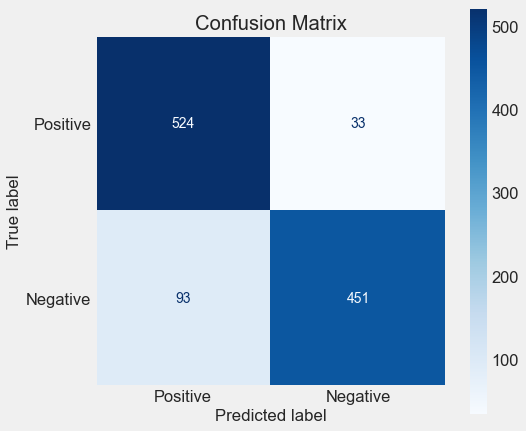

,F1,Recall,Precision
0,0.877432,0.829044,0.931818


In [19]:
f.confusion_report(x_boost, X_lem_val, y_lem_val)

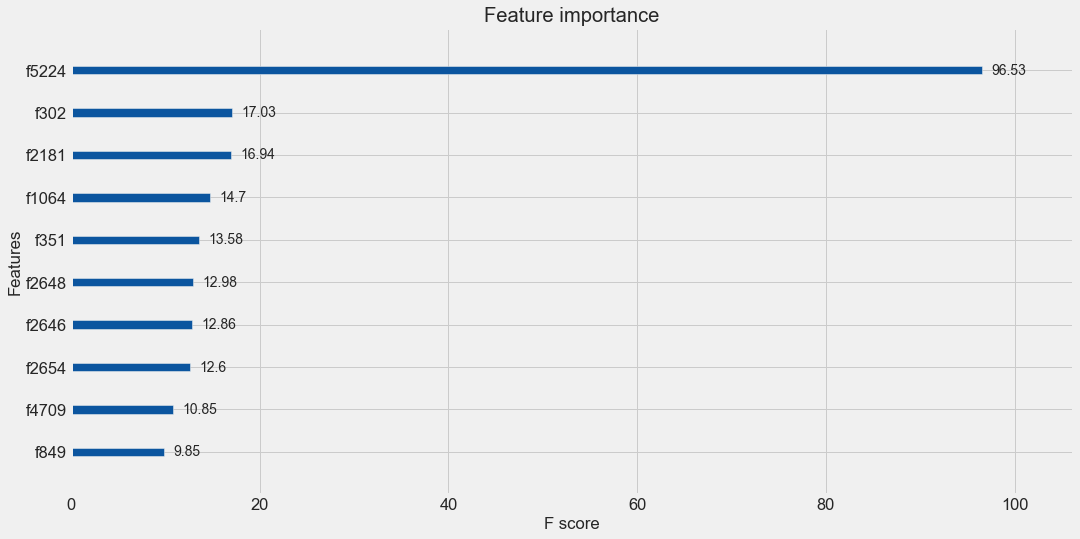

In [20]:
# grabbing the booster
booster = x_boost[1].get_booster()

# grabing importance dictionary
importance = booster.get_score(importance_type="gain")

# setting feature names for the plot
x_boost[1].get_booster().feature_names = x_boost[0].get_feature_names()

# rounding values
for key in importance.keys():
    importance[key] = round(importance[key],2)

# plotting
fig, ax=plt.subplots(figsize=(16,8))
plot_importance(importance, ax=ax, max_num_features=10, importance_type='gain', show_values=True)
plt.show()

In [21]:
fig, ax=plt.subplots(figsize=(500,250))
xgb.plot_tree(x_boost[1], ax=ax, num_trees=0)
# plt.rcParams['figure.figsize'] = [250, 175]
plt.show()

## Tuning

In [ ]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }